In [28]:
from netCDF4 import Dataset
import cchdo_tools as cchdo
import matplotlib.pyplot as plt
import numpy as np
import gsw
import cartopy.crs as ccrs
import cartopy.feature as cfeature


## Demo comparing CanNEMO CMOC to obs
First specify the fields that we want to plot giving separate variable names for the WOCE standard and the NEMO output Note that the order matters.

In [29]:
woce_fields = ['bottle_oxygen','total_carbon','nitrate']
nemo_fields = ['O2', 'DIC', 'NO3']

Now we can point to the path where the cruise data are stored. In this case here, we're extracting every cruise that can be found in 'datapath'

In [29]:
datapath = '/HOME/ras/datasets/cchdo/subset/'
cchdo.update_expo_list(datapath = datapath)
cruises = cchdo.extract_all_expos(datapath = datapath, fields_in = woce_fields)
remap_fields = woce_fields + ['pressure']
obs_remap = {}

The next block of code does the objective mapping. The optional fields 'xvar' specifies which variable to use along the x-axis. This can be 'longitude' or 'latitude', but I prefer distance (which is the total distance that the ship had traversed since the first station) since it's an actual distance unit and makes the gridding more consistent. 'yvar' can either be 'pressure' or 'sigma0', 'sigma2', 'rhoinsitu'. Here I'm choosing sigma2 because we're plotting full-depth variables. I prefer to smooth in density space because most measured quantities have consistent density correlations rather than pressure-based correlations. Note that this part of the routine can take quite a bit of time to compute and potentially a lot of memory.

In [29]:
for expo in cruises.keys():
  obs_remap[expo] = cchdo.grid_transect_variables(cruises[expo]['bottle'], remap_fields,xvar='distance',yvar='sigma2',xcorr=5e5,ycorr=0.1,nx=100,ny=40,npass=2)

Read 3 expocodes from /HOME/ras/datasets/cchdo/subset/
Expocode 33RR20090320 has 195 files


/HOME/ras/python/cchdo_toolkit/cchdo_tools.py:154: RuntimeWarning: invalid value encountered in greater
  tempvar = expo_ncvars[field][:]
/HOME/ras/python/cchdo_toolkit/cchdo_tools.py:150: RuntimeWarning: invalid value encountered in greater
  tempvar = expo_ncvars[field][:]


Expocode 33RO20161119 has 213 files
Expocode 318M20091121 has 251 files
Begin objective mapping of fields with 2 passes, 500000.000000 x length scale, 0.100000 y length scale
Calculating weights from 6540 inputs and 2465 outputs
Calculating internal weights from 6540 inputs
Number of measurements for bottle_oxygen: 6540
Standard deviation of initial guess: 24.695433
RMS adjustment after pass 2: 1.464515
Number of measurements for total_carbon: 6540
Standard deviation of initial guess: 71.373445
RMS adjustment after pass 2: 1.106839
Number of measurements for nitrate: 6540
Standard deviation of initial guess: 13.014949
RMS adjustment after pass 2: 0.204944
Number of measurements for pressure: 6540
Standard deviation of initial guess: 713.181550
RMS adjustment after pass 2: 41.673319
Begin objective mapping of fields with 2 passes, 500000.000000 x length scale, 0.100000 y length scale
Calculating weights from 4640 inputs and 1896 outputs
Calculating internal weights from 4640 inputs
Numb

Now we're extracting some of the necessary fields from NEMO so we can grid variables onto the transect

In [25]:
physfile = '/HOME/ras/model_output/cccma/ofb-502/ofb-502_1m_89040101_89041231_grid_T.nc'
bgcfile  = '/HOME/ras/model_output/cccma/ofb-502/ofb-502_1m_89040101_89041231_ptrc_T.nc'
phys_fields = ['votemper','vosaline','deptht','nav_lon','nav_lat'];
model = {}
for field in phys_fields:
  model[field] = Dataset(physfile).variables[field][:].copy()
Dataset(physfile).close()
for field in nemo_fields:
  model[field] = Dataset(bgcfile).variables[field][:].copy()
Dataset(bgcfile).close()
model['sigma2'] = gsw.density.sigma2(model['vosaline'],model['votemper'])

The next block handles the regridding of the model output onto the transect and the plotting

Gridding votemper with shape (46, 292, 362)
Gridding vosaline with shape (46, 292, 362)
Gridding sigma2 with shape (46, 292, 362)
Gridding O2 with shape (46, 292, 362)
Gridding DIC with shape (46, 292, 362)
Gridding NO3 with shape (46, 292, 362)


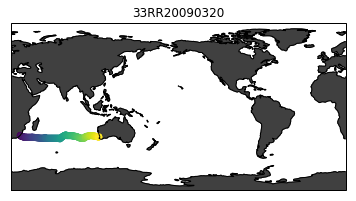

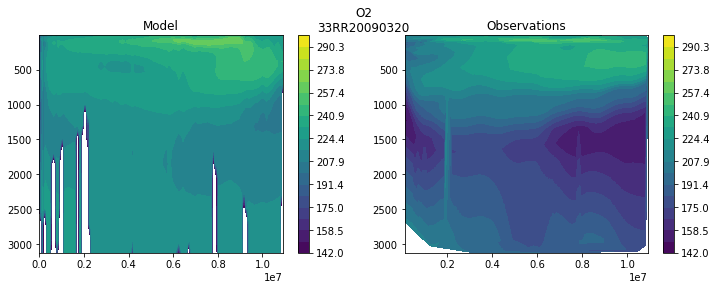

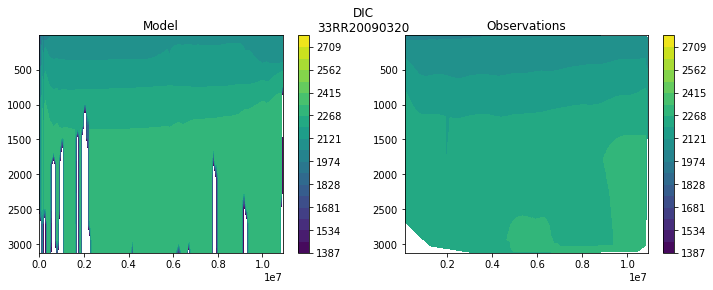

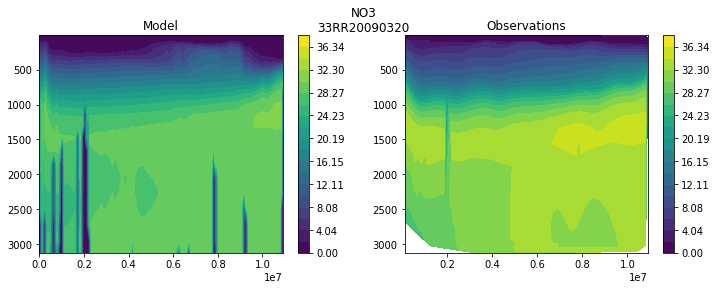

Gridding votemper with shape (46, 292, 362)
Gridding vosaline with shape (46, 292, 362)
Gridding sigma2 with shape (46, 292, 362)
Gridding O2 with shape (46, 292, 362)
Gridding DIC with shape (46, 292, 362)
Gridding NO3 with shape (46, 292, 362)


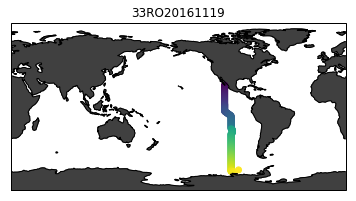

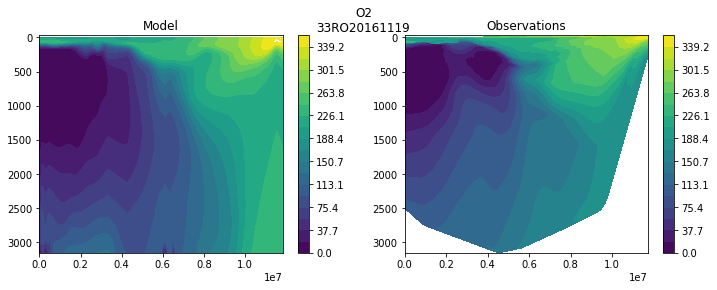

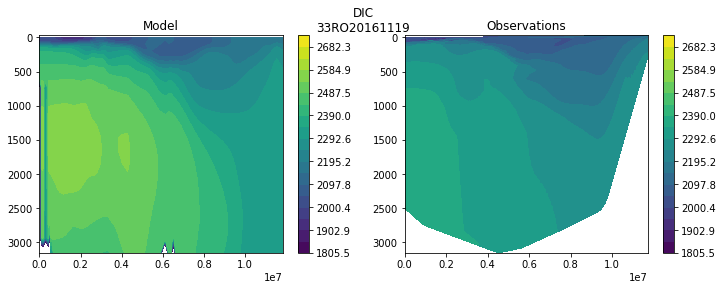

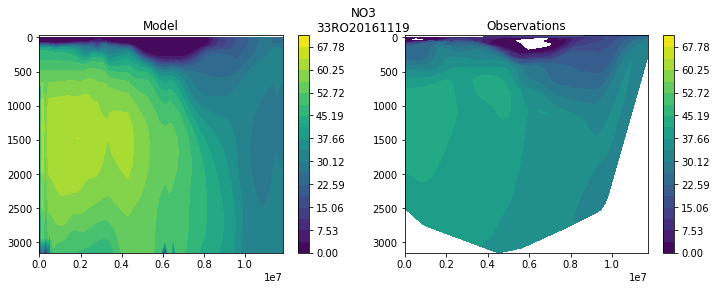

Gridding votemper with shape (46, 292, 362)
Gridding vosaline with shape (46, 292, 362)
Gridding sigma2 with shape (46, 292, 362)
Gridding O2 with shape (46, 292, 362)
Gridding DIC with shape (46, 292, 362)
Gridding NO3 with shape (46, 292, 362)


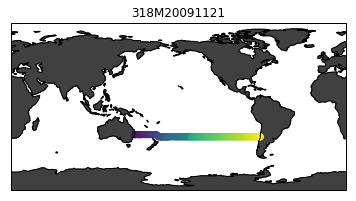

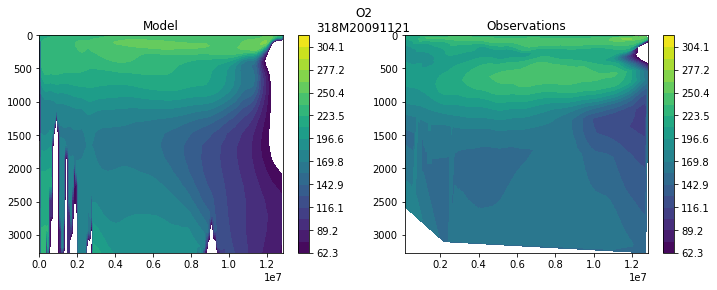

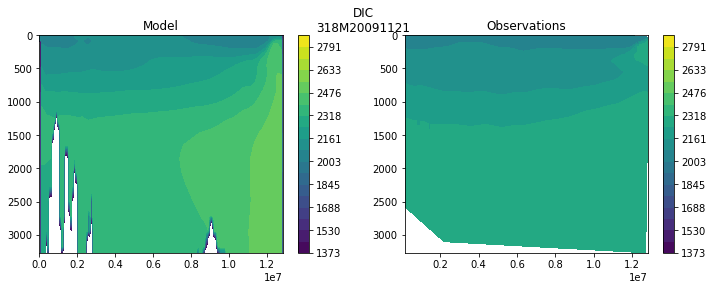

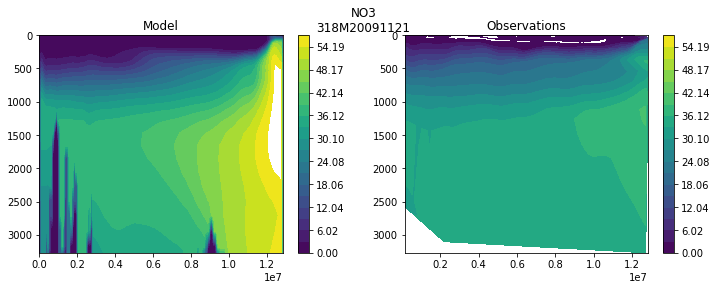

In [30]:
fields_to_remap = ['votemper','vosaline','sigma2']+nemo_fields;
model_remap = {}
proj = ccrs.PlateCarree(central_longitude=0.5*(20+380))
scale = 2
ncontour = 20
yvar = 'pressure'
for expo in cruises.keys():
  model_remap[expo] = cchdo.map_gridded_fields_to_expo(cruises[expo]['station'],model,fields_to_remap)
  fig = plt.figure()
  ax = plt.axes(projection=proj)
  ax.scatter(cruises[expo]['station']['longitude'],cruises[expo]['station']['latitude'], c = cruises[expo]['station']['time'], transform=ccrs.PlateCarree())
  ax.add_feature(cfeature.COASTLINE)
  ax.add_feature(cfeature.LAND,facecolor='0.25')
  ax.set_global()
  plt.title(expo.upper())
  plt.show()

  for idx in range(0,len(woce_fields)):
    
    modelval = model_remap[expo][nemo_fields[idx]]
    modelval = np.ma.masked_where(modelval == 0., modelval)
    meanval = modelval.mean()
    std = modelval.std()
    minval = max(meanval - std*scale, 0.)
    maxval = meanval + std*scale
    contours = np.linspace(minval,maxval,ncontour)
    
    ylim = (obs_remap[expo][yvar].min(),obs_remap[expo][yvar].max())    
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.contourf(model_remap[expo]['distance'],model_remap[expo][yvar],model_remap[expo][nemo_fields[idx]],contours)
    plt.ylim(ylim)
    plt.title('Model')
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.subplot(1,2,2)
    
    x = obs_remap[expo]['distance'].flatten()
    y = obs_remap[expo][yvar].flatten()
    z = obs_remap[expo][woce_fields[idx]].flatten()
    notnan = np.logical_not(np.isnan(z))
    x = x[notnan]
    y = y[notnan]
    z = z[notnan]
    
    plt.tricontourf(x,y,z,contours)
    plt.colorbar()
    plt.gca().invert_yaxis()    
    plt.title('Observations')
    plt.suptitle("%s\n%s" % (nemo_fields[idx],expo))
    plt.show()
  